In [188]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from keras.optimizers import Adam
from keras.initializers import RandomNormal

In [189]:
path = []
celeb = "img_align_celeba/img_align_celeba/"
for i in os.listdir(celeb):
    if '.jpg' in i:
        path.append(os.path.join(celeb,i))

In [190]:
path = path[:10000]

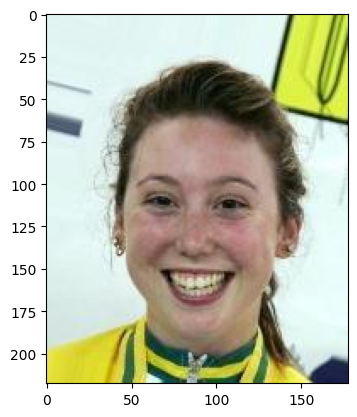

In [191]:
img = Image.open(path[69])
plt.imshow(img)
plt.show()

In [192]:
img.size

(178, 218)

In [193]:
images = [np.array((Image.open(i).crop((26, 51, 154, 179))).resize((64,64))) for i in path] #Crop image to 128,128 box and resize image to 64,64

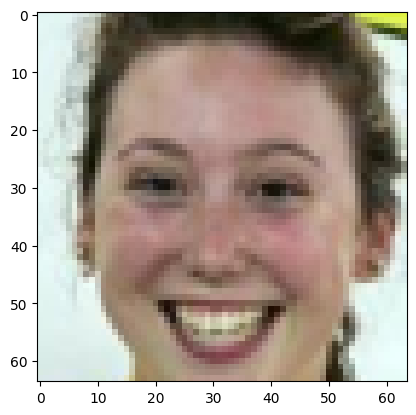

In [194]:
plt.imshow(images[69])
plt.show()

In [195]:
#X_train = np.array(images).astype(np.float32) / 255.0
X_train = np.array(images).astype(np.float32)
X_train = (X_train / 127.5) - 1.0

In [196]:
X_train.shape

(10000, 64, 64, 3)

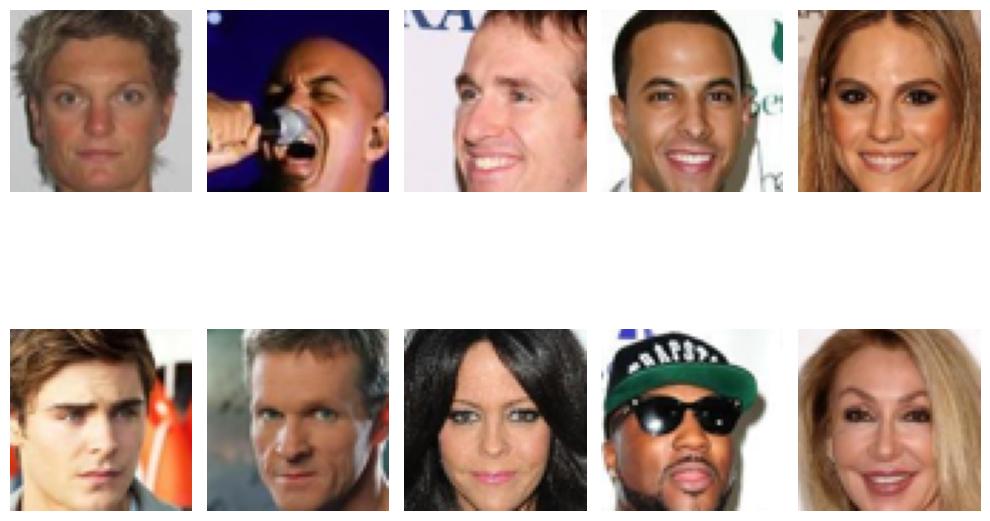

In [197]:
plt.figure(figsize = (10,8))
i,k = 100,1

while k <= 10:
    plt.subplot(2,5,k)
    plt.imshow((X_train[i]+1)/2)
    plt.axis('off')
    k += 1
    i += 100

plt.tight_layout()
plt.show()

In [198]:
noise_shape = 100

In [199]:
generator = Sequential([ #Up sampling
        Dense(4*4*512), #8192 units
        Reshape([4,4,512]), #4,4,512
        Conv2DTranspose(256,kernel_size = 4, strides = 2, padding = "same"), #strides double the size to 8,8,256
        LeakyReLU(alpha = 0.2), # x if x >= 0 else 0.2 x 
        BatchNormalization(), #Scales  to variance 1
        Conv2DTranspose(128,kernel_size = 4, strides = 2, padding = "same"), #again doubles the size to to 16,16,128
        LeakyReLU(alpha = 0.2),
        BatchNormalization(),
        Conv2DTranspose(64,kernel_size = 4, strides = 2, padding = "same"), #32,32,64
        LeakyReLU(alpha = 0.2),
        BatchNormalization(),
        Conv2DTranspose(3,kernel_size = 4,strides = 2, padding = "same",activation = "tanh") #64,64,3 range 0-1
])

In [200]:
generator.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_44 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [201]:
discriminator = Sequential([ #Down sampling
    Conv2D(32,kernel_size = 4,strides = 2,padding = "same"), #stride halfs the image size to 32,32,32
    Conv2D(64,kernel_size = 3,strides = 2,padding = "same"), #16,16,64
    LeakyReLU(alpha = 0.2),
    #BatchNormalization(),
    Dropout(0.5),
    Conv2D(128,kernel_size = 3,strides = 2, padding = "same"), #8,8,128
    LeakyReLU(alpha = 0.2),
    #BatchNormalization(),
    Conv2D(256,kernel_size = 4,strides = 2, padding = "same"), #4,4,256
    LeakyReLU(alpha = 0.2),
    Flatten(), #4*4*256 = 4096 units
    Dropout(0.5),
    Dense(1,activation = "sigmoid") #range 0-1
])

In [202]:
discriminator.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_45 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_46 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_47 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [203]:
gan = Sequential([
    generator,
    discriminator
])

In [204]:
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),loss = 'binary_crossentropy')
discriminator.trainable = False #Freeze the discriminator when generator is training

In [205]:
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss = 'binary_crossentropy')

In [206]:
gan.layers

[<Sequential name=sequential_21, built=False>,
 <Sequential name=sequential_22, built=False>]

In [207]:
gan.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_21 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_22 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

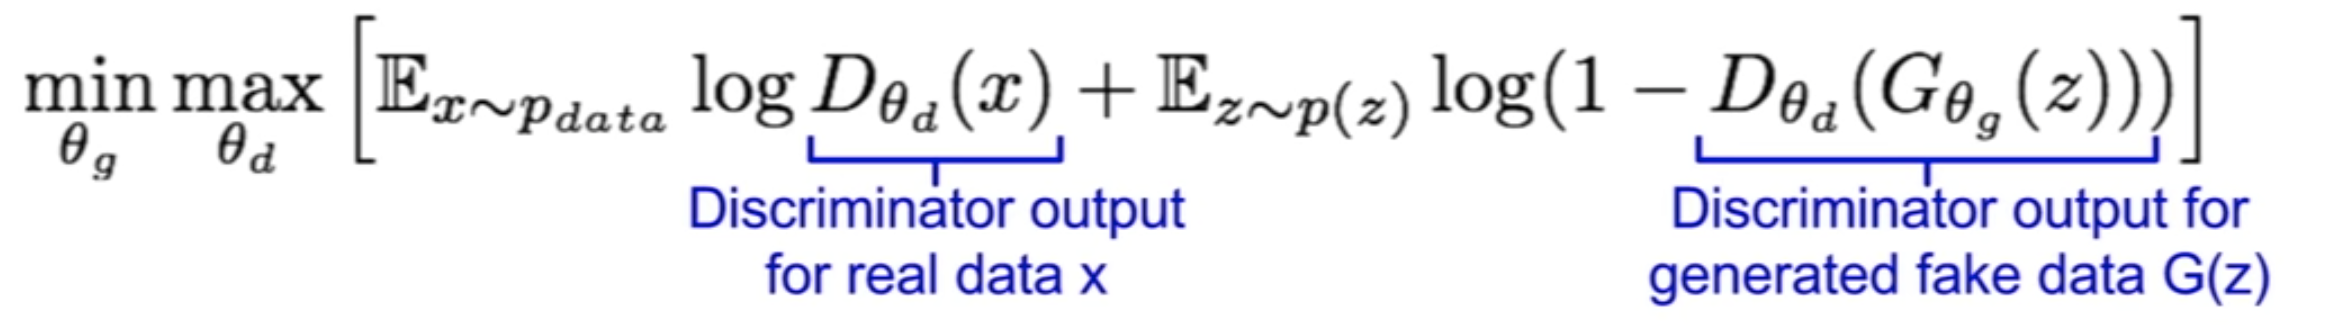

In [208]:
epochs = 100
batch_size = 128

In [209]:
X_train.shape

(10000, 64, 64, 3)

In [210]:
batches = X_train.shape[0]//batch_size
batches

78

In [211]:
d_loss = []
g_loss = []

Epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


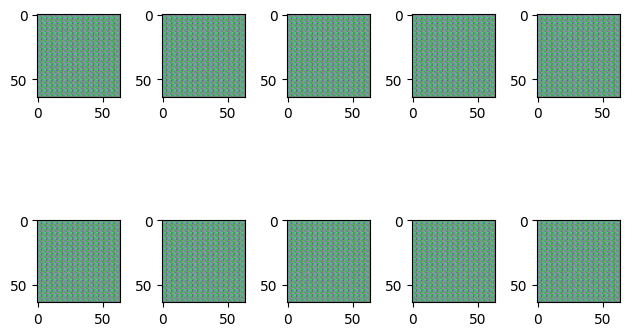

Epoch: 1,  Loss: D_real = 0.2501707077026367, D_fake = 0.24856707453727722,  G = 0.03136371076107025
Epoch:  1
Epoch: 2,  Loss: D_real = 0.20766450464725494, D_fake = 0.20699892938137054,  G = 0.01577237993478775
Epoch:  2
Epoch: 3,  Loss: D_real = 0.19344565272331238, D_fake = 0.19303230941295624,  G = 0.010540253482758999
Epoch:  3
Epoch: 4,  Loss: D_real = 0.1862780898809433, D_fake = 0.18597973883152008,  G = 0.007951289415359497
Epoch:  4
Epoch: 5,  Loss: D_real = 0.21057415008544922, D_fake = 0.21054638922214508,  G = 0.24974991381168365
Epoch:  5
Epoch: 6,  Loss: D_real = 0.28087276220321655, D_fake = 0.2812449634075165,  G = 0.3455783724784851
Epoch:  6
Epoch: 7,  Loss: D_real = 0.3404635190963745, D_fake = 0.34070634841918945,  G = 0.4035322964191437
Epoch:  7
Epoch: 8,  Loss: D_real = 0.3850267827510834, D_fake = 0.38522884249687195,  G = 0.4483727812767029
Epoch:  8
Epoch: 9,  Loss: D_real = 0.4196401536464691, D_fake = 0.41980135440826416,  G = 0.48503679037094116
Epoch:  9

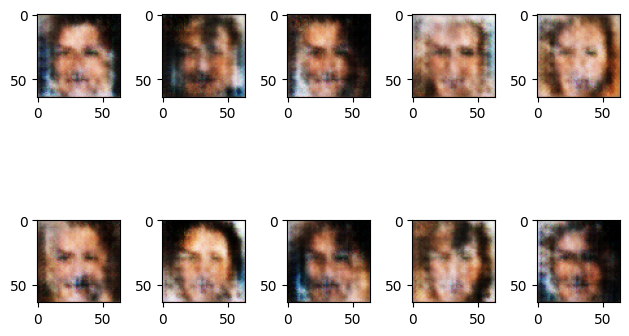

Epoch: 11,  Loss: D_real = 0.4694164991378784, D_fake = 0.46951064467430115,  G = 0.5383133292198181
Epoch:  11
Epoch: 12,  Loss: D_real = 0.4880649447441101, D_fake = 0.4881339967250824,  G = 0.5590193271636963
Epoch:  12
Epoch: 13,  Loss: D_real = 0.5037456154823303, D_fake = 0.5037974119186401,  G = 0.5768234133720398
Epoch:  13
Epoch: 14,  Loss: D_real = 0.517127513885498, D_fake = 0.5171680450439453,  G = 0.59253990650177
Epoch:  14
Epoch: 15,  Loss: D_real = 0.5287876725196838, D_fake = 0.5288146734237671,  G = 0.6052486300468445
Epoch:  15
Epoch: 16,  Loss: D_real = 0.5389712452888489, D_fake = 0.5390061736106873,  G = 0.6167206168174744
Epoch:  16
Epoch: 17,  Loss: D_real = 0.5479548573493958, D_fake = 0.5479847192764282,  G = 0.6271044611930847
Epoch:  17
Epoch: 18,  Loss: D_real = 0.5559229254722595, D_fake = 0.5559450387954712,  G = 0.6360594630241394
Epoch:  18
Epoch: 19,  Loss: D_real = 0.5631920695304871, D_fake = 0.5632064938545227,  G = 0.6440227031707764
Epoch:  19
Epo

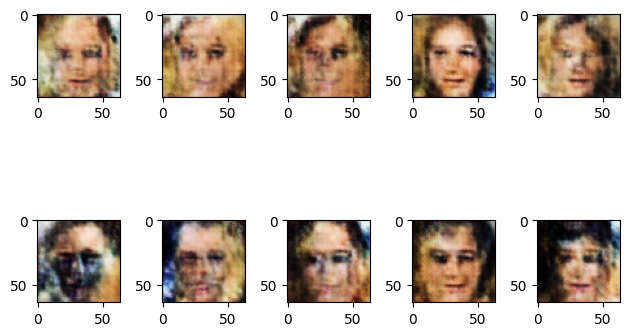

Epoch: 21,  Loss: D_real = 0.5754407048225403, D_fake = 0.5754501819610596,  G = 0.6576177477836609
Epoch:  21
Epoch: 22,  Loss: D_real = 0.5806853175163269, D_fake = 0.5806978344917297,  G = 0.6634743809700012
Epoch:  22
Epoch: 23,  Loss: D_real = 0.5855030417442322, D_fake = 0.5855119228363037,  G = 0.6688708066940308
Epoch:  23
Epoch: 24,  Loss: D_real = 0.5898999571800232, D_fake = 0.5899061560630798,  G = 0.67409747838974
Epoch:  24
Epoch: 25,  Loss: D_real = 0.5939499139785767, D_fake = 0.5939551591873169,  G = 0.6788183450698853
Epoch:  25
Epoch: 26,  Loss: D_real = 0.5976735353469849, D_fake = 0.5976769328117371,  G = 0.6832643151283264
Epoch:  26
Epoch: 27,  Loss: D_real = 0.6010897159576416, D_fake = 0.6010929942131042,  G = 0.6873375177383423
Epoch:  27
Epoch: 28,  Loss: D_real = 0.6042395234107971, D_fake = 0.6042384505271912,  G = 0.6910542249679565
Epoch:  28
Epoch: 29,  Loss: D_real = 0.6070579886436462, D_fake = 0.6070659160614014,  G = 0.6944868564605713
Epoch:  29
Epo

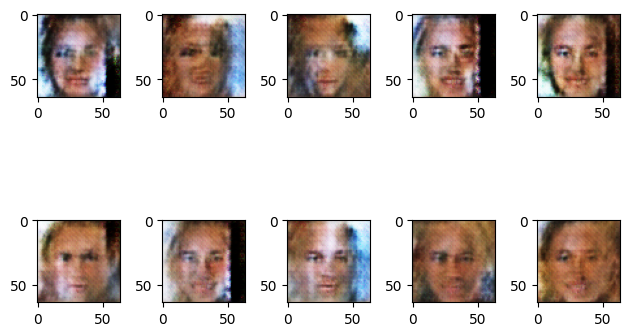

Epoch: 31,  Loss: D_real = 0.6122069358825684, D_fake = 0.6122052669525146,  G = 0.7015897631645203
Epoch:  31
Epoch: 32,  Loss: D_real = 0.6144281029701233, D_fake = 0.6144225597381592,  G = 0.7045783400535583
Epoch:  32
Epoch: 33,  Loss: D_real = 0.6165928244590759, D_fake = 0.6165859699249268,  G = 0.7079319953918457
Epoch:  33
Epoch: 34,  Loss: D_real = 0.6186993718147278, D_fake = 0.6186935305595398,  G = 0.7110823392868042
Epoch:  34
Epoch: 35,  Loss: D_real = 0.6206853985786438, D_fake = 0.6206812858581543,  G = 0.713988721370697
Epoch:  35
Epoch: 36,  Loss: D_real = 0.6225695610046387, D_fake = 0.6225646138191223,  G = 0.7167328000068665
Epoch:  36
Epoch: 37,  Loss: D_real = 0.6242560148239136, D_fake = 0.6242489218711853,  G = 0.7193474769592285
Epoch:  37
Epoch: 38,  Loss: D_real = 0.6259058117866516, D_fake = 0.6259034872055054,  G = 0.7219157218933105
Epoch:  38
Epoch: 39,  Loss: D_real = 0.6275704503059387, D_fake = 0.6275666356086731,  G = 0.7241524457931519
Epoch:  39
Ep

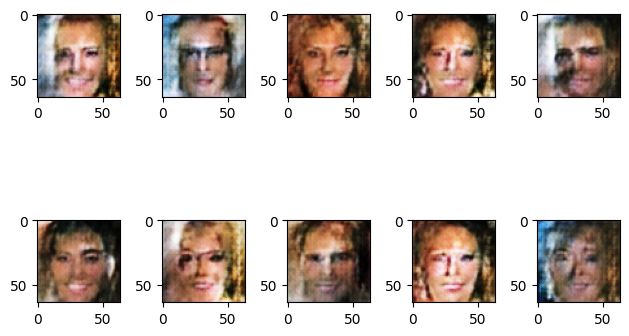

Epoch: 41,  Loss: D_real = 0.6305058598518372, D_fake = 0.6305015683174133,  G = 0.7287457585334778
Epoch:  41
Epoch: 42,  Loss: D_real = 0.6319254636764526, D_fake = 0.6319186091423035,  G = 0.7307329177856445
Epoch:  42
Epoch: 43,  Loss: D_real = 0.6332306861877441, D_fake = 0.6332275867462158,  G = 0.7325232625007629
Epoch:  43
Epoch: 44,  Loss: D_real = 0.6345134377479553, D_fake = 0.634509265422821,  G = 0.734201967716217
Epoch:  44
Epoch: 45,  Loss: D_real = 0.6357247829437256, D_fake = 0.6357210278511047,  G = 0.7358940243721008
Epoch:  45
Epoch: 46,  Loss: D_real = 0.6368491053581238, D_fake = 0.6368398666381836,  G = 0.7376394271850586
Epoch:  46
Epoch: 47,  Loss: D_real = 0.637911319732666, D_fake = 0.637907087802887,  G = 0.7393785715103149
Epoch:  47
Epoch: 48,  Loss: D_real = 0.6389644145965576, D_fake = 0.6389598250389099,  G = 0.740776538848877
Epoch:  48
Epoch: 49,  Loss: D_real = 0.6399885416030884, D_fake = 0.6399847269058228,  G = 0.742201566696167
Epoch:  49
Epoch: 

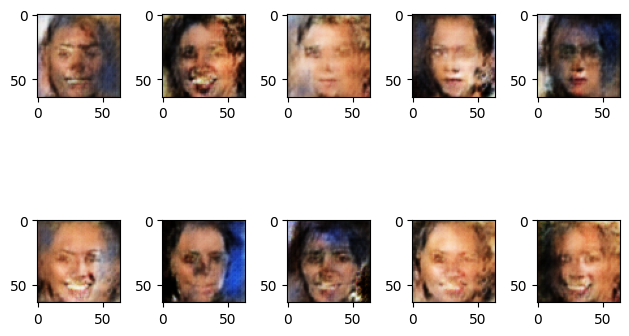

Epoch: 51,  Loss: D_real = 0.641869843006134, D_fake = 0.6418634653091431,  G = 0.7450671195983887
Epoch:  51
Epoch: 52,  Loss: D_real = 0.642753541469574, D_fake = 0.642748236656189,  G = 0.746460497379303
Epoch:  52
Epoch: 53,  Loss: D_real = 0.6436218023300171, D_fake = 0.6436168551445007,  G = 0.7476397752761841
Epoch:  53
Epoch: 54,  Loss: D_real = 0.644394040107727, D_fake = 0.6443900465965271,  G = 0.7488957047462463
Epoch:  54
Epoch: 55,  Loss: D_real = 0.6451728343963623, D_fake = 0.6451672315597534,  G = 0.7501013278961182
Epoch:  55
Epoch: 56,  Loss: D_real = 0.6459031701087952, D_fake = 0.6458978652954102,  G = 0.751462996006012
Epoch:  56
Epoch: 57,  Loss: D_real = 0.6466076970100403, D_fake = 0.646604597568512,  G = 0.7526904940605164
Epoch:  57
Epoch: 58,  Loss: D_real = 0.6472979187965393, D_fake = 0.6472920775413513,  G = 0.7539195418357849
Epoch:  58
Epoch: 59,  Loss: D_real = 0.6479302048683167, D_fake = 0.6479278802871704,  G = 0.7551774382591248
Epoch:  59
Epoch: 6

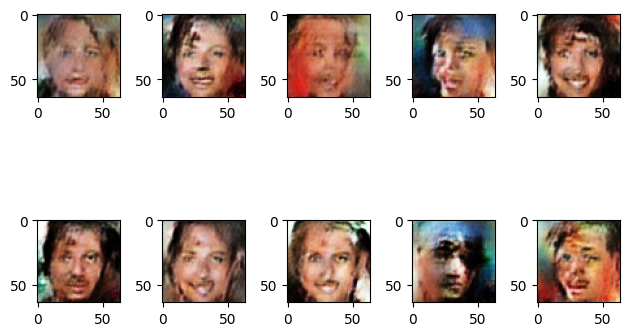

Epoch: 61,  Loss: D_real = 0.6492106318473816, D_fake = 0.6492053866386414,  G = 0.7574563026428223
Epoch:  61
Epoch: 62,  Loss: D_real = 0.6498259902000427, D_fake = 0.6498206257820129,  G = 0.7585171461105347
Epoch:  62
Epoch: 63,  Loss: D_real = 0.650416374206543, D_fake = 0.6504110097885132,  G = 0.7595753073692322
Epoch:  63
Epoch: 64,  Loss: D_real = 0.6509820222854614, D_fake = 0.6509761214256287,  G = 0.7605900168418884
Epoch:  64
Epoch: 65,  Loss: D_real = 0.6515107750892639, D_fake = 0.6515066623687744,  G = 0.761633574962616
Epoch:  65
Epoch: 66,  Loss: D_real = 0.6520363688468933, D_fake = 0.6520302295684814,  G = 0.7626727223396301
Epoch:  66
Epoch: 67,  Loss: D_real = 0.6525614261627197, D_fake = 0.652554988861084,  G = 0.7636024355888367
Epoch:  67
Epoch: 68,  Loss: D_real = 0.6530460119247437, D_fake = 0.6530413627624512,  G = 0.7646559476852417
Epoch:  68
Epoch: 69,  Loss: D_real = 0.6535003185272217, D_fake = 0.6534940600395203,  G = 0.7656330466270447
Epoch:  69
Epoc

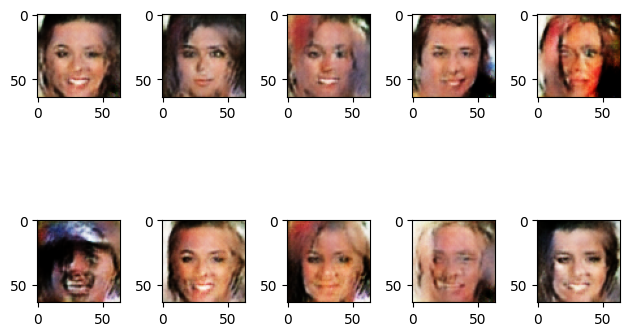

Epoch: 71,  Loss: D_real = 0.654374361038208, D_fake = 0.6543689966201782,  G = 0.767488956451416
Epoch:  71
Epoch: 72,  Loss: D_real = 0.654786229133606, D_fake = 0.6547826528549194,  G = 0.76853346824646
Epoch:  72
Epoch: 73,  Loss: D_real = 0.6552124619483948, D_fake = 0.6552068591117859,  G = 0.7694297432899475
Epoch:  73
Epoch: 74,  Loss: D_real = 0.6556046605110168, D_fake = 0.6556006073951721,  G = 0.7703291177749634
Epoch:  74
Epoch: 75,  Loss: D_real = 0.6559808254241943, D_fake = 0.6559765338897705,  G = 0.7712600231170654
Epoch:  75
Epoch: 76,  Loss: D_real = 0.6563626527786255, D_fake = 0.6563560366630554,  G = 0.7721173167228699
Epoch:  76
Epoch: 77,  Loss: D_real = 0.6567347645759583, D_fake = 0.6567279696464539,  G = 0.7729367613792419
Epoch:  77
Epoch: 78,  Loss: D_real = 0.6570860147476196, D_fake = 0.6570819020271301,  G = 0.7737734317779541
Epoch:  78
Epoch: 79,  Loss: D_real = 0.6574232578277588, D_fake = 0.657419741153717,  G = 0.7746885418891907
Epoch:  79
Epoch: 

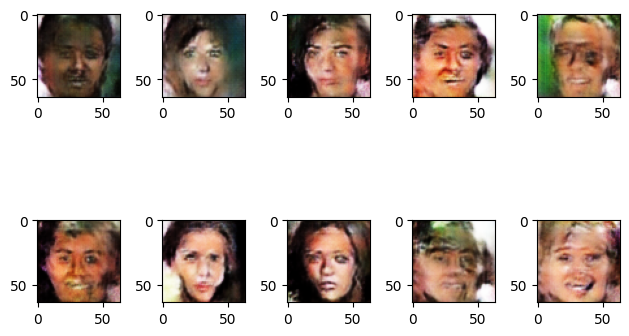

Epoch: 81,  Loss: D_real = 0.6580559611320496, D_fake = 0.658050000667572,  G = 0.7765081524848938
Epoch:  81
Epoch: 82,  Loss: D_real = 0.6583276391029358, D_fake = 0.658321738243103,  G = 0.7774213552474976
Epoch:  82
Epoch: 83,  Loss: D_real = 0.6586059331893921, D_fake = 0.6586012244224548,  G = 0.7782831192016602
Epoch:  83
Epoch: 84,  Loss: D_real = 0.6588862538337708, D_fake = 0.6588805317878723,  G = 0.7791906595230103
Epoch:  84
Epoch: 85,  Loss: D_real = 0.6591446995735168, D_fake = 0.6591390371322632,  G = 0.7801316380500793
Epoch:  85
Epoch: 86,  Loss: D_real = 0.6594125628471375, D_fake = 0.659406840801239,  G = 0.7810304760932922
Epoch:  86
Epoch: 87,  Loss: D_real = 0.6596671938896179, D_fake = 0.6596617102622986,  G = 0.7819147706031799
Epoch:  87
Epoch: 88,  Loss: D_real = 0.6598753333091736, D_fake = 0.659869372844696,  G = 0.782843291759491
Epoch:  88
Epoch: 89,  Loss: D_real = 0.6600887179374695, D_fake = 0.6600825786590576,  G = 0.7837521433830261
Epoch:  89
Epoch:

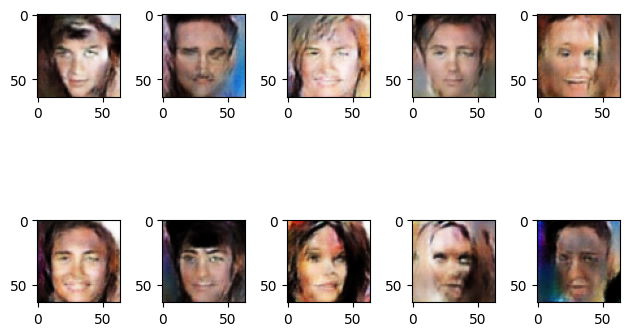

Epoch: 91,  Loss: D_real = 0.6605157256126404, D_fake = 0.6605110764503479,  G = 0.7856371998786926
Epoch:  91
Epoch: 92,  Loss: D_real = 0.6607068181037903, D_fake = 0.6607009768486023,  G = 0.7865709662437439
Epoch:  92
Epoch: 93,  Loss: D_real = 0.660885751247406, D_fake = 0.6608805656433105,  G = 0.787521243095398
Epoch:  93
Epoch: 94,  Loss: D_real = 0.6610425710678101, D_fake = 0.6610346436500549,  G = 0.7885338068008423
Epoch:  94
Epoch: 95,  Loss: D_real = 0.6611825227737427, D_fake = 0.6611772775650024,  G = 0.7895365953445435
Epoch:  95
Epoch: 96,  Loss: D_real = 0.6612807512283325, D_fake = 0.661275327205658,  G = 0.7906814813613892
Epoch:  96
Epoch: 97,  Loss: D_real = 0.6613658666610718, D_fake = 0.6613619327545166,  G = 0.791808009147644
Epoch:  97
Epoch: 98,  Loss: D_real = 0.6614696979522705, D_fake = 0.6614665389060974,  G = 0.7930184602737427
Epoch:  98
Epoch: 99,  Loss: D_real = 0.6615275144577026, D_fake = 0.6615239381790161,  G = 0.7942773103713989
Epoch:  99
Epoch

In [212]:
for epoch in range(epochs):
    print("Epoch: ",epoch)
    for i in range(batches):

        noise = np.random.uniform(-1,1,size=[batch_size,noise_shape]) #noise of shape 128,100
        gen_img = generator.predict_on_batch(noise)
        # gen_img = generator.predict_on_batch(noise)
        # gen_img += np.random.normal(0, 0.02, size=gen_img.shape)
        # gen_img = np.clip(gen_img, -1.0, 1.0)

        #Train the discriminator

        # real_imgs = X_train[i*batch_size:(i+1)*batch_size]
        # real_imgs += np.random.normal(0, 0.05, size=real_imgs.shape)
        # real_imgs = np.clip(real_imgs, -1.0, 1.0)

        train_dataset = X_train[i * batch_size : (i+1) * batch_size] #Get mini batches
        #Training on real image
        train_label = np.ones(shape = (batch_size,1)) * 0.9 #Real image has output 1
        discriminator.trainable = True #Make it trainable 
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        #Training on the fake image
        train_label = np.zeros(shape = (batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_img,train_label)

        #Train the generator
        for j in range(2):
            noise = np.random.uniform(-1,1,size=[batch_size,noise_shape])
            train_label = np.ones(shape = (batch_size,1))
            discriminator.trainable = False
            g_loss1  = gan.train_on_batch(noise,train_label)
            g_loss.append(g_loss1)

        d_loss.append(d_loss1 + d_loss2)
        #g_loss.append(g_loss1)

    if epoch % 10 == 0:
        fake = generator.predict(np.random.uniform(-1,1,size=[10,noise_shape]))
        for k in range(10):
            plt.subplot(2,5,k+1)
            plt.imshow((fake[k] + 1)/2)
        plt.tight_layout()
        plt.show()
    
    print(f'Epoch: {epoch+1},  Loss: D_real = {d_loss1}, D_fake = {d_loss2},  G = {g_loss1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


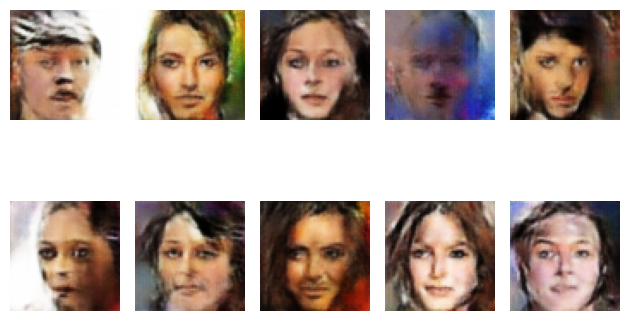

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


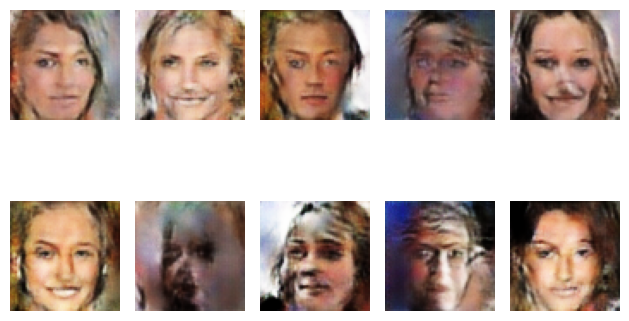

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


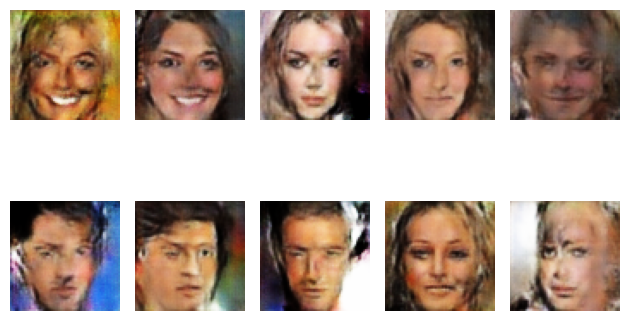

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


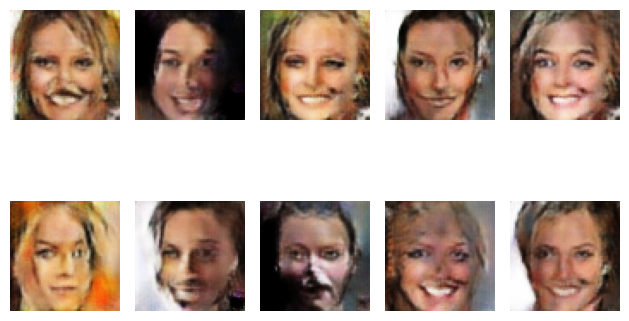

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


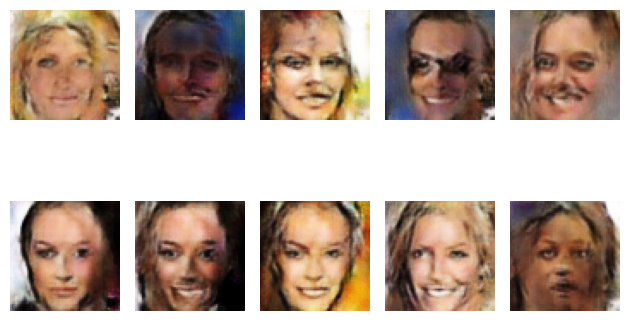

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


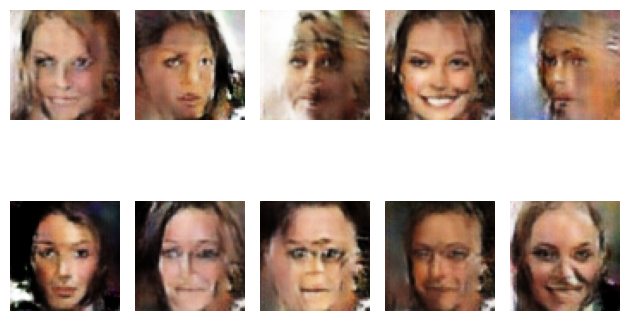

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


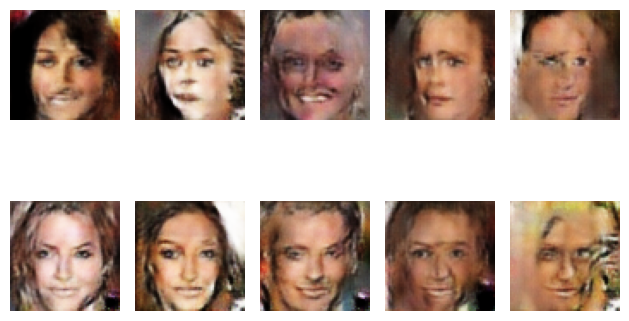

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


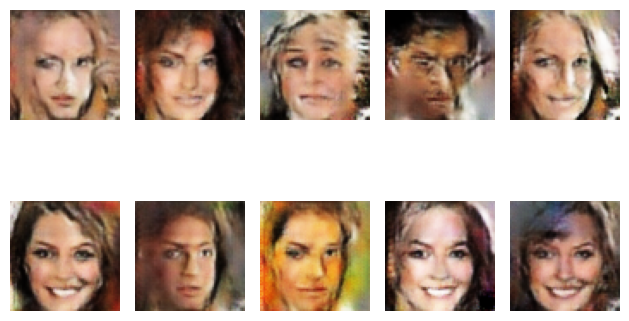

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


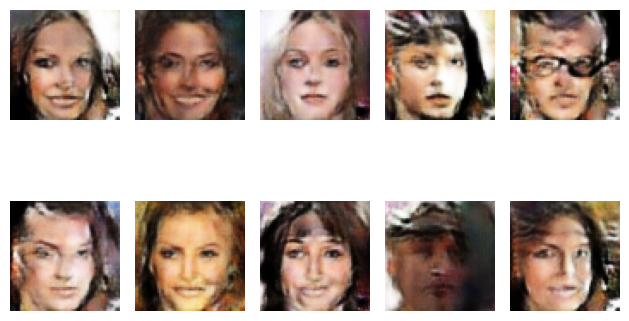

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


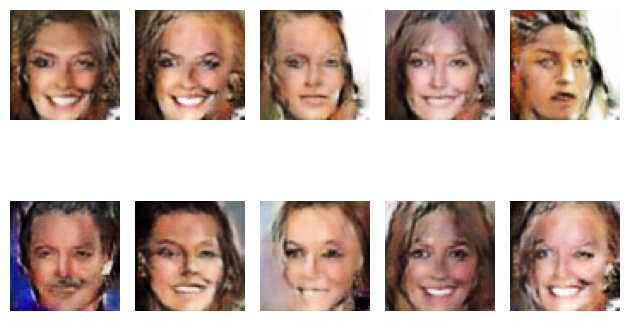

In [216]:
for k in range(10):
    for i in range(10):
        noise = np.random.uniform(-1,1,size=[10,noise_shape])
        fake = generator.predict(noise)
        plt.subplot(2,5,i+1)
        plt.imshow((fake[i] + 1) / 2)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

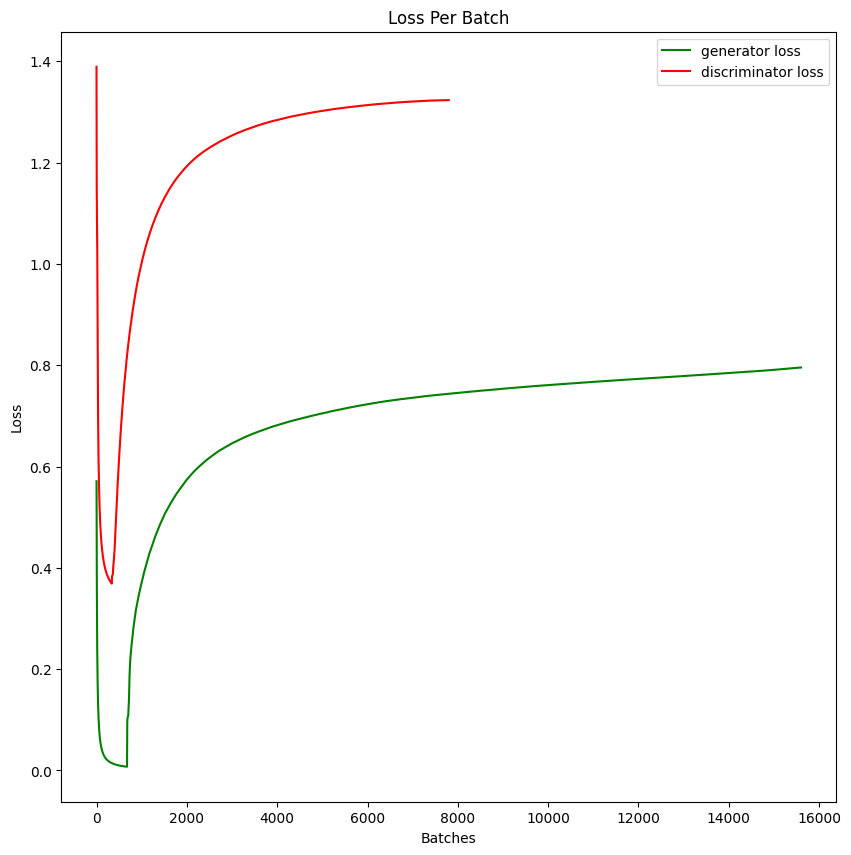

In [217]:
plt.figure(figsize = (10,10))
plt.plot(g_loss,color = 'green',label = 'generator loss')
plt.plot(d_loss,color = 'red', label = 'discriminator loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss Per Batch')
plt.legend()
plt.show()

In [218]:
gan.save("faces_dcgan_model.h5")